In [2]:
from lib.preamble import *

%matplotlib inline

data = []

# Import Data

In [3]:
paths = glob("../data/2024-01-10_NiPS3_inPlane_raman/d*")
paths.sort()

In [4]:
# import backgrounds
import csv

def _read_csv(path):
	rows = []
	with open(path) as f:
		r = csv.reader(f, delimiter="\t")
		for row in r:
			if len(row) == 0:
				return rows
			rows.append(row)
	return rows

def custom_import_spectra(p):
	d = np.array(_read_csv(p))[:, :-1]
	# convert strings to floats
	d = d.astype(float)

	ar = xr.DataArray(
		d[:, 1],
		coords={
			'wavelength': d[:, 0]
		}
	)

	# get the metadata
	number, exposure = p.replace(".", "_").split("s")[0].split("_")[-1].split("x")

	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": p.split("data/")[-1].split(".")[0],
		"number": int(number),
		"exposure": float(exposure),
	}
	ar.name = ar.attrs["name"]
	
	return ar

import difflib

def background_substract_substract(sel, b):
	d =  sel - b.interp(wavelength=sel.wavelength, kwargs={"fill_value": np.nan})
	d.attrs = sel.attrs
	d.name = sel.name
	d.attrs["background"] = b

	d = d.dropna("wavelength")

	d /= d.attrs["number"]
	d /= d.attrs["exposure"]

	return d

bkg = [custom_import_spectra(p) for p in paths if p.endswith(".asc") and "bkg" in p]

# create a script that
def background_substract(sel, b=None):
	
	exposure = sel.attrs["exposure"]
	wavelength = (sel.wavelength.min(), sel.wavelength.max())

	# get all backgrounds with the same exposure
	same_exposure = [b for b in bkg if b.attrs["exposure"] == exposure]

	# find the same wavelength
	same_wavelength = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] and b.wavelength.max() >= wavelength[1]]

	# if there is only one, use it
	if len(same_wavelength) == 1: b=same_wavelength[0]

	# if there are more, use the one with the closest wavelength
	elif len(same_wavelength) > 1:
		b_name = difflib.get_close_matches(sel, [b.name for b in same_wavelength], n=1, cutoff=0)[0]
		b = [b for b in same_wavelength if b.name == b_name][0]
	
	else:
		# check if there is a partial match of the wavelength
		partial_match = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] or b.wavelength.max() >= wavelength[1]]
		if len(partial_match) == 1: b=partial_match[0]
		
		# take the closest one
		elif len(partial_match) > 1:
			# b_name = difflib.get_close_matches(sel, [b.name for b in partial_match], n=1, cutoff=0)[0]
			# b = [b for b in partial_match if b.name == b_name][0]
			b = sorted(partial_match, key=lambda x: np.abs(x.wavelength.mean() - sel.wavelength.mean()))[0]
		
		else:
			warnings.warn(f"no background found for {sel.name}")
			return sel
	
	return background_substract_substract(sel, 
		b * sel.attrs["number"] / b.attrs["number"]
	)
 
pprint([b.name for b in bkg])

['2024-01-10_NiPS3_inPlane_raman/d002_bkg_blackPaper_10x5s']


In [5]:

# import all from 2023-12-06 and 07 done with custom script
import h5py

def import_custom_script(p):
	with h5py.File(p, "r") as f:
		angle_count = len(np.unique(f['apt_angle']))

		if "magnet_field" in f:
			field = f["magnet_field"][::angle_count]
		else:
			field = np.array([np.nan])

		angle = f["apt_angle"][:angle_count]
		wavelength = f["wavelength"][0]
		counts = f["counts"][:].reshape(field.shape[0], angle.shape[0], wavelength.shape[0])

		time = f["time"][:].reshape(field.shape[0], angle.shape[0])

		if "temperature" in f:
			temperature = f["temperature"][:].reshape(field.shape[0], angle.shape[0])
		else:
			temperature = np.full_like(time, np.nan)

		if "position" in f:
			position = f["position"][:].reshape(field.shape[0], angle.shape[0], 3)
		else:
			position = np.full_like(counts, np.nan)

		exposure = f["data_full"]["spectrometer"]["exposure"][0]
		number = f["data_full"]["spectrometer"]["number"][0]

	ar = xr.DataArray(
		counts,
		dims=["field", "angle", "wavelength"],
		coords={
			"field": field,
			"angle": angle,
			"wavelength": wavelength,
		},
		attrs={
			"exposure": exposure,
			"number": number,
		}
	)

	# add coord time
	ar.coords["time"] = (
		["field", "angle"],
		time
	)

	# add coord temperature
	ar.coords["temperature"] = (
		["field", "angle"],
		temperature
	)

	return ar

def import_files(p):

	try:
		ar = import_custom_script(p)
	except:
		print(f"Error importing:\t{p}")
		return None

	# if ar is None:
		# return None
	
	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": ".".join(p.split("data/")[-1].split(".")[:-1]),
	}
	ar.name = ar.attrs["name"]


	diff_field = np.diff(ar.field)
	if np.all(diff_field > 0):
		ar.attrs["field_direction"] = 1.
	elif np.all(diff_field < 0):
		ar.attrs["field_direction"] = -1.
	else:
		ar.attrs["field_direction"] = np.nan

	return ar

data = [import_files(p) for p in paths if p.endswith(".h5")]
data = [d for d in data if d is not None]
data = [background_substract(d) for d in data]

pprint({i: d.name for i, d in enumerate(data)})

{0: '2024-01-10_NiPS3_inPlane_raman/d001_linPolExc_linDetPol_165K_flake01_20mW',
 1: '2024-01-10_NiPS3_inPlane_raman/d003_circPolExc_linDetPol_100K_flake01_20mW',
 2: '2024-01-10_NiPS3_inPlane_raman/d004_circPolExc_linDetPol_50K_flake01_20mW',
 3: '2024-01-10_NiPS3_inPlane_raman/d005_circPolExc_linDetPol_10K_flake01_20mW',
 4: '2024-01-10_NiPS3_inPlane_raman/d006_linPolExc_linDetPol_10K_flake01_20mW'}


# Preliminaries

In [8]:
sel = data[-1]
print(sel.name)

laser_wavelength = sel.sel(wavelength=slice(None, 563)).mean(["field", "angle"]).idxmax("wavelength").values.item()
peak_wavelength = sel.sel(wavelength=slice(568.5, 570.5)).mean(["field", "angle"]).idxmax("wavelength").values

2024-01-10_NiPS3_inPlane_raman/d006_linPolExc_linDetPol_10K_flake01_20mW


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


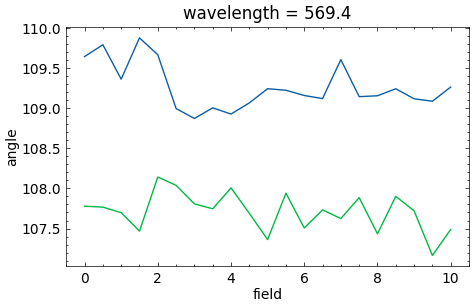

In [15]:
pol_laser = polarisation_xarray(sel.sel(wavelength=laser_wavelength) +10)
pol_wavelength = polarisation_xarray(sel.sel(wavelength=peak_wavelength) +10)

# plot the polarisation
pol_laser.angle.plot()
pol_wavelength.angle.plot()
plt.legend()

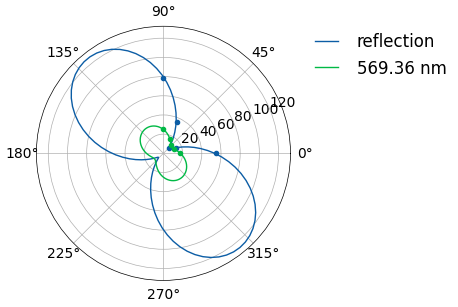

In [20]:
# plot the peanut
# make a polar plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

def plot(d, label="", ax=ax):
	fit, _ = fit_cos_sqr(d.angle * 2, d.values)
	points = d.assign_coords(angle=d.angle * np.pi/180 * 2).plot(
		linestyle="none", marker="o", ax=ax,
		_labels=False
	)
	angles = np.linspace(0, 2*np.pi, 100)
	ax.plot(angles, cos_sqr(angles*180/np.pi, *fit), color=points[0].get_color(), label=label)
	
plot(sel.sel(wavelength=laser_wavelength, field=0)+10, "reflection")
plot(sel.sel(wavelength=peak_wavelength, field=0)+10, f"{peak_wavelength:.2f} nm")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [6]:
def raman(wl, laser): return 1e7 * (1/laser - 1/wl)
def raman_inv(raman, laser): return 1/(1/laser - 1e-7 * raman)

def raman_ticks(laser, ax = None):
	if ax is None:  ax = plt.gca()
	ax.xaxis.set_ticks_position('bottom')
	return ax.secondary_xaxis('top', functions=(lambda x: raman(x, laser), lambda x: raman_inv(x, laser)))

In [12]:
(sel.exposure, sel.number)

(5.0, 10)

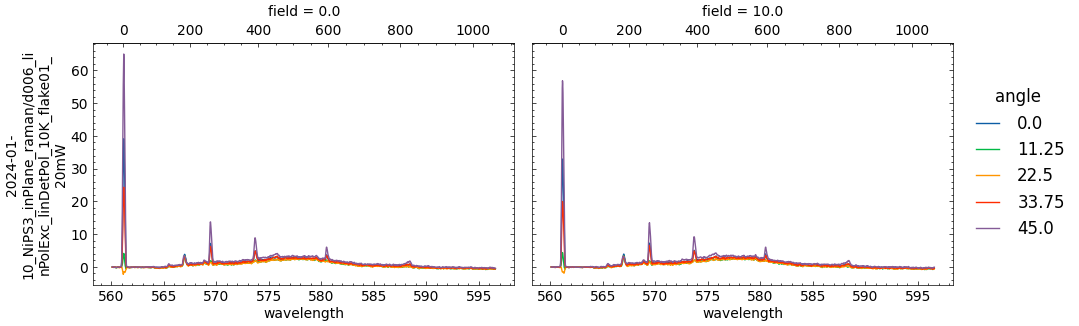

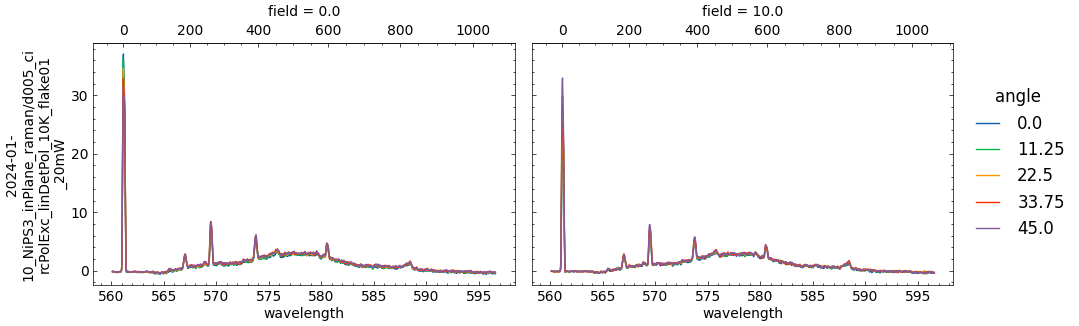

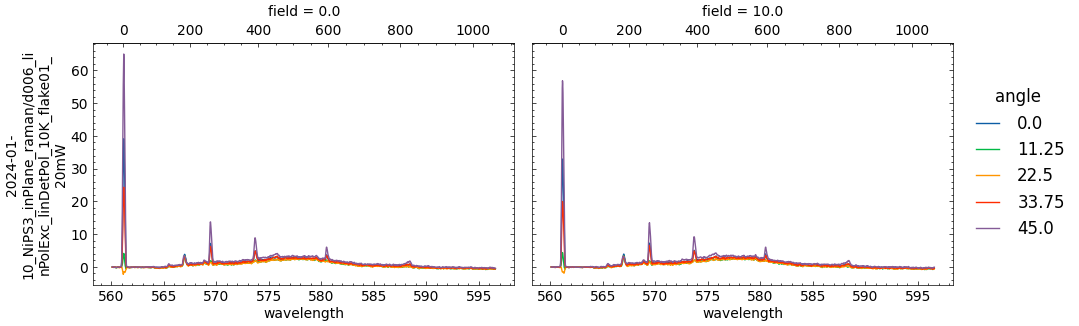

In [9]:
def plot(d):
	# coarsen(field=5, boundary="pad").mean().\
	# sel(wavelength=slice(563, 580)).\
	d.\
	sortby("field").\
	sel(field=[0, 10]).\
	rolling(wavelength=5).mean().\
	plot.line(x="wavelength", hue="angle", col="field", figsize=FIGSIZE_WIDE)
	
	for ax in plt.gcf().axes: raman_ticks(laser_wavelength, ax)
	return plt.gcf()

plot(data[-2])
plot(data[-1])

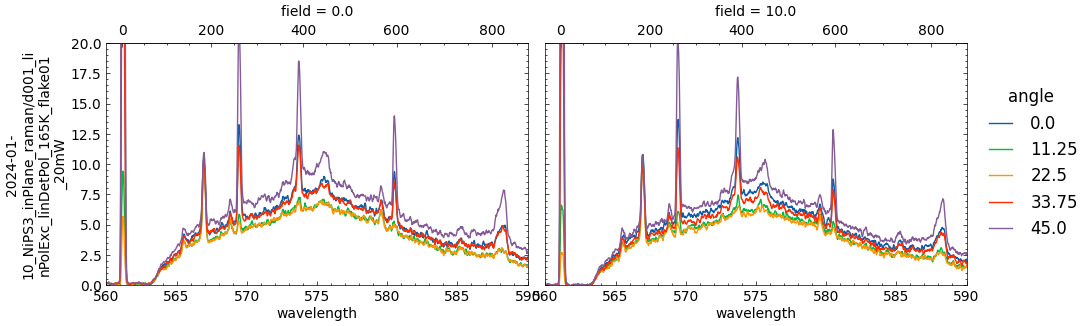

In [19]:
f = plot(data[0])
for a in f.axes: a.set_xlim(560, 590)
for a in f.axes: a.set_ylim(0, 20)

(560.0, 564.0)

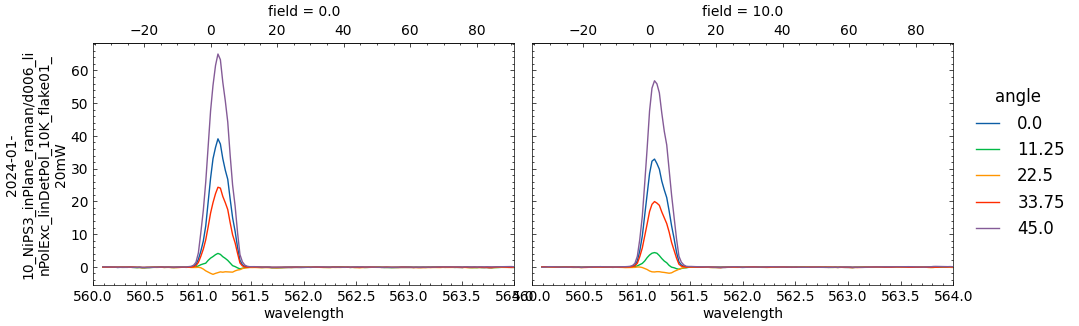

In [13]:
plot(data[-1])
plt.xlim(560,  564)

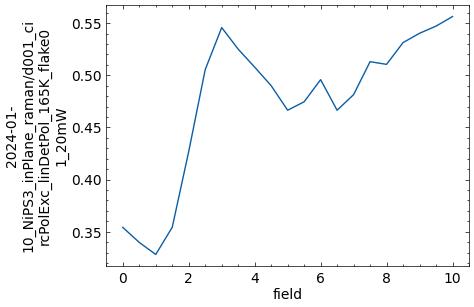

In [9]:
max_laser = sel.sel(wavelength=slice(None, 563)).rolling(wavelength=5).mean().max("wavelength")
max_line = sel.sel(wavelength=slice(563, None)).rolling(wavelength=5).mean().max("wavelength")


(max_line.mean("angle")/max_laser.mean("angle")).plot()

In [41]:
def polarisation_downsampled(sel, bins=40):
	sel = sel.where(~np.isnan(sel), drop=True)
	sel = sel.coarsen(wavelength=sel.wavelength.shape[0]//bins, boundary="trim").mean()
	pol = polarisation_xarray(sel.assign_coords(angle=2*sel.angle), fast=False)
	pol = pol.sortby("field")
	return pol

In [68]:
%%time
pol = polarisation_downsampled(sel + 1, bins=100)

CPU times: user 6.83 s, sys: 3 ms, total: 6.84 s
Wall time: 6.85 s


In [78]:
import numba as nb

@nb.vectorize
def fit_cos_sqr(angle, intens, p0=None):
	if p0 is None:
		p0 = [intens.max() - intens.min(), 90, intens.min()]
	popt, pcov = sp.optimize.curve_fit(cos_sqr, angle, intens, 
		p0=p0,
		bounds=(
			[0, -np.inf, 0],
			[np.inf, np.inf, np.inf]
		)
	)
	return popt, pcov



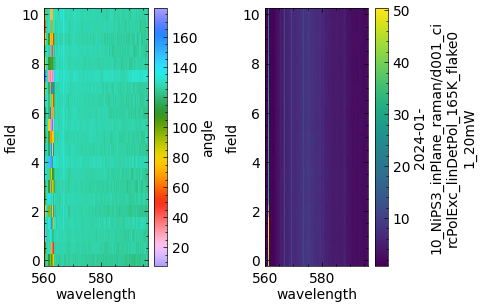

In [54]:
plt.subplot(121)
pol.angle.plot(cmap=CMAP_CYCLIC)
plt.subplot(122)
(sel+1).mean("angle").plot()
plt.show()

In [16]:
sig = data[0].isel(field=0, angle=0) * 5
bkg = data[0].background / 10

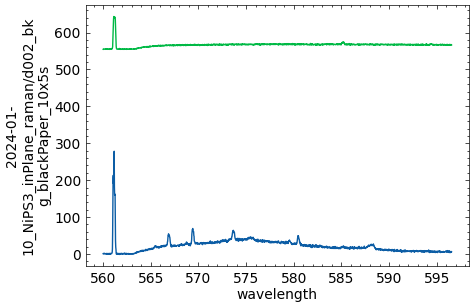

In [24]:
sig.plot()
bkg.plot()